# Librarys

Bibliotheksreferenzen
- OpenAI Gymnasium: https://github.com/Farama-Foundation/Gymnasium
- NumPy: https://numpy.org/
- Matplotlib: https://matplotlib.org/

In [31]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Training

Im Training wird mit genetischen Algorithmen ein kleines Modell zum Spielen der Anwendung aufgebaut

## Parameter der genetischen Algorithmen

In [32]:
population_size = 100
num_generations = 50
mutation_rate = 0.1
elitism_size = int(0.1 * population_size)

# Funktionen für die Erstellung der gentischen Algorithmen

In [33]:
def evaluate(individual, env, num_episodes=10):
    """
    Bewertet ein Individuum über mehrere Episoden.
    
    Parameters:
    - individual: Ein Gewichtungsvektor zur Entscheidung über Aktionen.
    - train_env: Die Gym-Umgebung, in der die Bewertung stattfindet.
    - num_episodes: Die Anzahl von Episoden zur Bewertung eines Individuums. Desto größer dieser Wert, desto konsistentere Ergebnise werden erzielt. Jedoch folgt diese Varibale einer Sättigungskurve!
    
    Returns:
    - Durchschnittliche Belohnung über die gewählten Episoden hinweg.
    """
    total_reward = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        for _ in range(1000):
            action = np.argmax(np.dot(state, individual))
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            if terminated or truncated:
                break
        total_reward += episode_reward
    return total_reward / num_episodes

def mutate(individual):
    """
    Führt Mutationen an einem Individuum durch.
    
    Parameters:
    - individual: Ein zu mutierender Gewichtungsvektor.
    
    Returns:
    - Mutiertes Individuum.
    """
    for i in range(individual.shape[0]):
        for j in range(individual.shape[1]):
            if np.random.rand() < mutation_rate:
                individual[i, j] += np.random.normal(0, 1)
    return individual

def crossover(parent1, parent2):
    """
    Kombiniert zwei Eltern zu einem Kind.
    
    Parameters:
    - parent1: Erster Elterngewichtungsvektor.
    - parent2: Zweiter Elterngewichtungsvektor.
    
    Returns:
    - Kind, eine Mischung der beiden Elternteile.
    """
    crossover_point = np.random.randint(parent1.shape[0])
    child = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
    return child

# Trainingsphase

In [34]:
def genetic_algorithm():
    """
    Führt den genetischen Algorithmus zur Optimierung durch.
    """
    env = gym.make('LunarLander-v3', gravity=-10.0, render_mode=None)
    best_scores = []
    
    # Initialisierung der Bevölkerung mit zufälligen Individuen
    population = [np.random.rand(env.observation_space.shape[0], env.action_space.n) for _ in range(population_size)]
    
    for generation in range(num_generations):
        # Bewertung der aktuellen Population
        scores = np.array([evaluate(individual, env) for individual in population])
        
        # Auswahl der besten Individuen (Elitismus)
        sorted_indices = np.argsort(scores)[::-1]
        population = [population[i] for i in sorted_indices]
        scores = scores[sorted_indices]

        best_score = scores[0]
        best_scores.append(best_score)
        print(f"Generation {generation}: Best Score = {best_score}")

        # Selektion und Erzeugung der nächsten Generation
        new_population = population[:elitism_size]  # Beste Individuen übernehmen

        while len(new_population) < population_size:
            parent_indices = np.random.choice(population_size // 2, 2, replace=False)
            parent1, parent2 = population[parent_indices[0]], population[parent_indices[1]]
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)

        population = new_population

    # Ausgabe des besten Individuums am Ende
    best_individual = population[0]

    # Speichern der besten Strategie
    np.save('best_strategy.npy', best_individual)
    
    return best_scores

best_scores = genetic_algorithm()

Generation 0: Best Score = -110.83671832986938
Generation 1: Best Score = -79.86681125630955
Generation 2: Best Score = -51.6038039604786
Generation 3: Best Score = -75.14179437086543
Generation 4: Best Score = 61.1452096610353
Generation 5: Best Score = -17.83934211308314
Generation 6: Best Score = -30.87263017407833
Generation 7: Best Score = 26.6071026487359
Generation 8: Best Score = 23.496201644368504
Generation 9: Best Score = 112.97453479460607
Generation 10: Best Score = 41.87021845691248
Generation 11: Best Score = 62.81740143411573
Generation 12: Best Score = 106.0721819170235
Generation 13: Best Score = 159.0264193358965
Generation 14: Best Score = 91.10302347904732
Generation 15: Best Score = 133.663700385892
Generation 16: Best Score = 150.99632794145006
Generation 17: Best Score = 208.3978772460899
Generation 18: Best Score = 203.9330324118945
Generation 19: Best Score = 237.3739290554783
Generation 20: Best Score = 215.58235457865575
Generation 21: Best Score = 247.21110

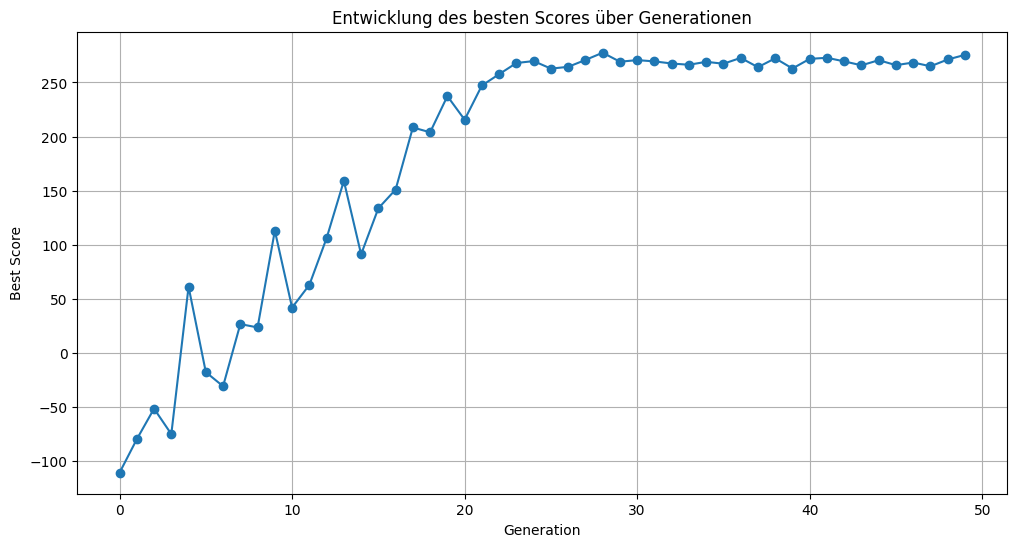

In [35]:
# Plot: des Lernfortschritts
plt.figure(figsize=(12, 6))
plt.plot(range(num_generations), best_scores, marker='o')
plt.title('Entwicklung des besten Scores über Generationen')
plt.xlabel('Generation')
plt.ylabel('Best Score')
plt.grid()
plt.show()

# Evaluation

In [36]:
def load_and_run(n_times=10, render_mode="human"):
    """
    Lädt die beste Strategie und führt sie in der Umgebung aus.
    
    Parameters:
    - n_times: Anzahl der Episoden, die gespielt werden sollen.
    - render_mode: Modus zur Visualisierung der Umgebung.
    """
    
    # Beste Strategie laden
    best_strategy = np.load('best_strategy.npy')
    play_env = gym.make('LunarLander-v3', gravity=-10.0, render_mode=render_mode)
    total_rewards = []
    err = []
    
    for episode in range(n_times):
        state, _ = play_env.reset(seed=np.random.randint(0, 10000))
        total_reward = 0
        for _ in range(1000):
            action = np.argmax(np.dot(state, best_strategy))
            state, reward, terminated, truncated, _ = play_env.step(action)
            total_reward += reward
            if terminated or truncated:
                break
        total_rewards.append(total_reward)
        err.append(abs(state[0]))
        print(f"Episode {episode + 1}: Score = {total_reward:.4f}, Error = {state[0]:.2f}")
        
    print(f"\nAverage Score over {n_times} episodes: {np.mean(total_rewards):.4f} with mean error from x = 0: {np.mean(err):.2f}")
    play_env.close()
    
load_and_run(n_times=1000, render_mode=None)

Episode 1: Score = 251.7953, Error = -0.02
Episode 2: Score = 275.1060, Error = -0.10
Episode 3: Score = 273.4751, Error = -0.11
Episode 4: Score = 283.1156, Error = -0.09
Episode 5: Score = 238.2991, Error = -0.11
Episode 6: Score = 280.8936, Error = -0.00
Episode 7: Score = 14.6049, Error = -0.23
Episode 8: Score = 270.3249, Error = 0.01
Episode 9: Score = 284.0879, Error = -0.04
Episode 10: Score = 225.4958, Error = 0.01
Episode 11: Score = 254.5563, Error = -0.11
Episode 12: Score = 224.1146, Error = -0.05
Episode 13: Score = 243.5014, Error = -0.11
Episode 14: Score = 271.4914, Error = -0.14
Episode 15: Score = 248.5213, Error = -0.05
Episode 16: Score = 259.1127, Error = 0.05
Episode 17: Score = 247.8343, Error = -0.03
Episode 18: Score = 226.7377, Error = -0.03
Episode 19: Score = 187.4599, Error = -0.54
Episode 20: Score = 232.7072, Error = 0.01
Episode 21: Score = 248.8155, Error = 0.04
Episode 22: Score = 264.5570, Error = -0.04
Episode 23: Score = 298.8816, Error = -0.02
Epi

In [37]:
# Test mit human Render-Mode
load_and_run(10,"human")

Episode 1: Score = 251.1666, Error = -0.13
Episode 2: Score = 302.9651, Error = 0.02
Episode 3: Score = 54.1400, Error = -0.17
Episode 4: Score = 259.5378, Error = -0.06
Episode 5: Score = 257.2723, Error = -0.10
Episode 6: Score = 253.4806, Error = -0.06
Episode 7: Score = 238.3915, Error = -0.02
Episode 8: Score = 236.8022, Error = -0.13
Episode 9: Score = 231.7518, Error = -0.14
Episode 10: Score = 240.7647, Error = -0.07

Average Score over 10 episodes: 232.6273 with mean error from x = 0: 0.09
